In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
import sys
sys.path.append('..')


import torch
import addict
import easydict
import numpy as np

from src.configs import config
from src.api import queue_manager as qm
from src.api import flask
from src.api import redis
from src.modules import dataset as ds
import src.api.response as rs
import src.modules.learner as lrn
from src.modules import smooth_tile_predictions as smt
import src.utils.preprocess as ps
import src.utils.rle as rle
from src.modules import inference
from src.models import regression_tree as rt

%load_ext autoreload
%autoreload 2

In [3]:
from collections import defaultdict
from glob import glob
from tqdm import tqdm
import pandas as pd
import pydicom as dicom

import pickle
import os
import re

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
import xgboost

In [5]:
# outputs = pickle.load(open(config.PATHS.OUTPUT/'CLEAN_VALIDATION.pkl', 'rb'))

In [6]:
def mapto(x):
    # 0,1,2,3 -> 0,1,2,3
    # 4-5 -> 4
    # false -> 0
    try:
        return int(x)
    except:
        return 4 if '4-5' in x else 0

In [7]:
def extract_features(v):
    sides = ['r', 'l']
    attributes = [
        'distortions', 'lymph_node', 
        'calcifications_benign', 'calcifications_malignant' ]

    mass_attributes = [
        'inhomogen', 'obscure_margin', 
        'irregular_shape', 'with_calc' ]

    data = {}

    for side in sides:
        for name in attributes:
            data['{}|{}'.format(side, name)] = v['prediction'][side][name]['response']['yes']
        for name in mass_attributes:
            data['{}|{}'.format(side, name)] = v['prediction'][side]['mass']['response'][name]

    for name in attributes:
        data['A{}|{}'.format(side, name)] = abs(
            v['prediction']['r'][name]['response']['yes']
            - v['prediction']['l'][name]['response']['yes']
        )
    for name in mass_attributes:
        data['A{}|{}'.format(side, name)] = abs(
            v['prediction']['r']['mass']['response'][name]
            - v['prediction']['l']['mass']['response'][name]
        )

    findings = defaultdict(list)
    for el in v['findings']:
        findings[el['type']].append(el['geometry'])

    for name in attributes + ['mass']:
#         data['area|sum|{}'.format(name)] = sum(findings[name])
        data['amount|{}'.format(name)] = len(findings[name])
#         data['area|max|{}'.format(name)] = max(findings[name] + [0])

    data['density'] = v['prediction']['density']['response']['ab']
    return data

In [8]:
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp


def plot_roc(targets, predictions):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(targets, predictions)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### EXTERNAL SET

In [40]:
outputs = pickle.load(open(config.PATHS.OUTPUT/'BIRADS12.pkl', 'rb'))

In [41]:
dataset = { o[0]: o[1] for o in outputs }
labels = list()
malignancy = list()
data = list()

for k, v in dataset.items():
    labels.append(int(k.split(os.path.sep)[0][-1]))
    malignancy.append('зло' in k.lower())
    data.append(extract_features(v))

data = pd.DataFrame(data)
labels = (np.array(labels) > 3).astype(np.int)
malignancy = np.array(malignancy)

In [169]:
loo = LeaveOneOut()
loo.get_n_splits(data)

LeaveOneOut()

targets = list()
predictions = list()

for train_index, test_index in tqdm(loo.split(data)):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    clf = GradientBoostingClassifier(random_state=0)
    clf.fit(X_train, y_train)
    GradientBoostingClassifier(random_state=0, n_estimators=100)

    predictions.extend(clf.predict_proba(X_test)[:, 1])
    targets.extend(y_test)
    clf.score(X_test, y_test)

341it [00:46,  7.14it/s]


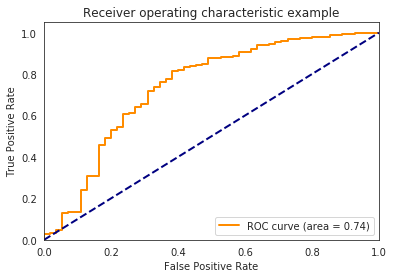

In [170]:
plot_roc(targets, predictions)

### TRAIN VALIDATION DATA

In [9]:
path = '/data/datasets/ssd/mammography/csv/ANNOTATIONS.csv'
annotations = pd.read_csv(path, low_memory=False)
annotations.head()

,ID,Исследователь,ID Исследования,Кейс,Источник,ID Группы,Группа,Тип Исследования,Часть тела,Модальность снимка,...,Ассиметрия,Кальцинаты,Внеочаговые кальцинаты,Внеочаговые кальцинаты.1,Локальная перестройка структуры МЖ,Образования,Инородные тела,Очаговые тени,Класс по BI-RADS,Интрамаммарный лимфоузел
0,52980,Ruslan Tarasov,73556,75389_20150417,NaN,190,Mammography_12_19-2,NaN,NaN,NaN,...,Нет,Нет,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51051,Iliya Fomenko,73556,75389_20150417,NaN,190,Mammography_12_19-2,NaN,NaN,NaN,...,Нет,Нет,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52981,Ruslan Tarasov,73557,800060_20151016,NaN,190,Mammography_12_19-2,NaN,NaN,NaN,...,Нет,Нет,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51052,Iliya Fomenko,73557,800060_20151016,NaN,190,Mammography_12_19-2,NaN,NaN,NaN,...,Нет,Есть Доброкачественные,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52982,Ruslan Tarasov,73558,806734_20130823,NaN,190,Mammography_12_19-2,NaN,NaN,NaN,...,Нет,Есть Доброкачественные,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
columns = ['Исследователь', 'Кейс', 'Класс по BI-RADS']
annotations = annotations[~annotations['Класс по BI-RADS'].isna()][columns]
annotations.head()

,Исследователь,Кейс,Класс по BI-RADS
6799,Михаил МАзо,258439_20160115,1
6801,Михаил МАзо,295066_20161109,1
6803,Михаил МАзо,209040_20160419,1
6839,Евгений Сушков,1545212_20171010,1
6841,Евгений Сушков,621617_20150708,2


In [11]:
annotations['Класс по BI-RADS'].value_counts()

2        10788
1         4792
3         2522
0         1626
4-5       1109
false       93
Name: Класс по BI-RADS, dtype: int64

In [12]:
outputs = pickle.load(open(config.PATHS.OUTPUT/'MEDICINA_VALIDATION.pkl', 'rb'))
dataset = { os.path.basename(o[0]): o[1] for o in outputs }

In [13]:
groups = annotations.groupby('Кейс').groups
groups = { k: v for k, v in groups.items() if k in dataset }
groups = { k: annotations.loc[v]['Класс по BI-RADS'].values for k, v in groups.items() }
groups = { k: np.bincount([ mapto(x) for x in v ], minlength=5) for k, v in groups.items() }

In [14]:
path = '/data/datasets/ssd/mammography/csv/birads_conclusion.csv'
birads = pd.read_csv(path, low_memory=False)
bgroups = birads.groupby('Case').groups
bgroups = { k: v for k, v in bgroups.items() if k in dataset }
bgroups = { k: birads.iloc[v].BIRADS.values[0] for k, v in bgroups.items() }
dataset = { k: v for k, v in dataset.items() if k in bgroups }

In [15]:
labels = list()
malignancy = list()
data = list()
keys = list()

for k, v in dataset.items():
    labels.append(bgroups[k])
    malignancy.append('зло' in k.lower())
    data.append(extract_features(v))
    keys.append(k)

In [16]:
outputs = pickle.load(open(config.PATHS.OUTPUT/'BIRADS12.pkl', 'rb'))
dataset = { o[0]: o[1] for o in outputs }

for k, v in dataset.items():
    labels.append(int(k.split(os.path.sep)[0][-1]))
    malignancy.append('зло' in k.lower())
    data.append(extract_features(v))
    keys.append(k)

data = pd.DataFrame(data)
labels = (np.array(labels) > 3).astype(np.int)
malignancy = np.array(malignancy)

### External Data

In [17]:
outputs = pickle.load(open(config.PATHS.OUTPUT/'MEDICINA_FULL.pkl', 'rb'))
dataset = { os.path.basename(o[0]): o[1] for o in outputs }

In [18]:
groups = annotations.groupby('Кейс').groups
groups = { k: v for k, v in groups.items() if k in dataset }
groups = { k: annotations.loc[v]['Класс по BI-RADS'].values for k, v in groups.items() }
groups = { k: np.bincount([ mapto(x) for x in v ], minlength=5) for k, v in groups.items() }
path = '/data/datasets/ssd/mammography/csv/birads_conclusion.csv'
birads = pd.read_csv(path, low_memory=False)
bgroups = birads.groupby('Case').groups
bgroups = { k: v for k, v in bgroups.items() if k in dataset }
bgroups = { k: birads.iloc[v].BIRADS.values[0] for k, v in bgroups.items() }
dataset = { k: v for k, v in dataset.items() if k in bgroups }

elabels = list()
emalignancy = list()
edata = list()

for k, v in dataset.items():
    elabels.append(bgroups[k])
    emalignancy.append('зло' in k.lower())
    edata.append(extract_features(v))

edata = pd.DataFrame(edata)
elabels = (np.array(elabels) > 3).astype(np.int)
emalignancy = np.array(emalignancy)

In [19]:
loo = LeaveOneOut()
loo.get_n_splits(data)

LeaveOneOut()

# BIRADS
targets = list()
predictions = list()

# Malignancy
mtargets = list()
mpredictions = list()

for train_index, test_index in tqdm(loo.split(data)):
    X_train, X_test = data.iloc[train_index], data.iloc[test_index]
    X_train = pd.concat([X_train, edata])
    y_train, y_test = labels[train_index], labels[test_index]
    y_train = np.concatenate([y_train, elabels])

    # BIRADS
    clf = xgboost.XGBClassifier(random_state=0)
    clf.fit(X_train, y_train)
    predictions.extend(clf.predict_proba(X_test)[:, 1])
    targets.extend(y_test)

    # Malignancy
    y_train, y_test = malignancy[train_index], malignancy[test_index]
    y_train = np.concatenate([y_train, emalignancy])

    mclf = xgboost.XGBClassifier(random_state=0)
    mclf.fit(X_train, y_train)
    mpredictions.extend(mclf.predict_proba(X_test)[:, 1])
    mtargets.extend(y_test)

580it [03:10,  3.02it/s]


In [30]:
loo = [{
    'case': k, 
    'prediction': p, 
    'target': t
} for k, p, t in zip(keys, predictions, targets) ]
loo = pd.DataFrame(loo)
loo.to_csv('loo.csv')

In [108]:
clf.save_model('../data/models/DecisionTreeRegressor/XGBOOST.pkl')

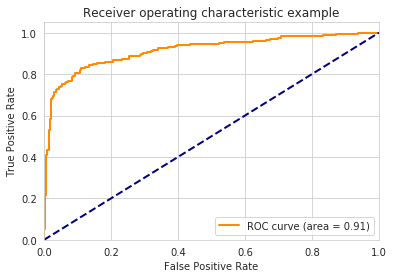

In [23]:
plot_roc(targets, predictions)

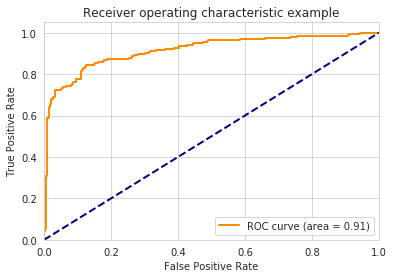

In [22]:
plot_roc(mtargets, mpredictions)

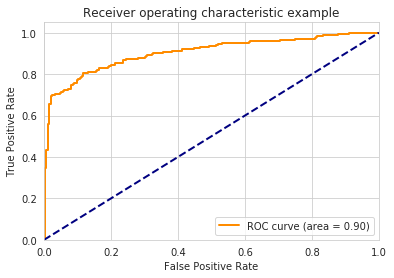

In [97]:
plot_roc(targets, predictions)

In [106]:
clf = xgboost.XGBClassifier(random_state=0)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Feature ranking:
1. r|obscure_margin --- 0.07937496155500412
2. r|calcifications_benign --- 0.06495901942253113
3. amount|mass --- 0.05439015105366707
4. r|distortions --- 0.05164175108075142
5. l|calcifications_benign --- 0.051129300147295
6. l|distortions --- 0.050179705023765564
7. r|inhomogen --- 0.04908161982893944
8. r|irregular_shape --- 0.04878934100270271
9. amount|distortions --- 0.04605110362172127
10. l|obscure_margin --- 0.044310785830020905
11. Al|obscure_margin --- 0.043747760355472565
12. Al|calcifications_benign --- 0.04039781168103218
13. l|irregular_shape --- 0.03850564360618591
14. Al|inhomogen --- 0.03727602958679199
15. Al|lymph_node --- 0.0366859994828701
16. l|inhomogen --- 0.03539038822054863
17. r|calcifications_malignant --- 0.03529016673564911
18. l|calcifications_malignant --- 0.0340459942817688
19. l|lymph_node --- 0.03401496261358261
20. r|lymph_node --- 0.03379925340414047
21. Al|irregular_shape --- 0.03266649320721626
22. Al|calcifications_malignant ---

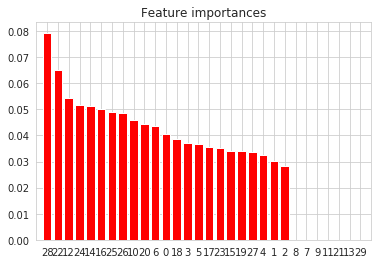

In [98]:
importances = clf.feature_importances_
# std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("{}. {} --- {}".format(f + 1, data.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices], color="r", 
        # yerr=std[indices], 
        align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

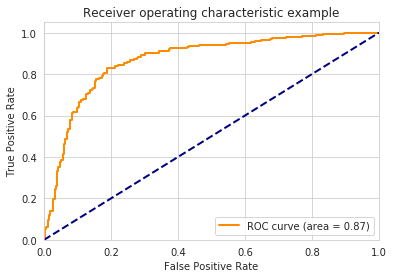

In [57]:
plot_roc(targets, predictions)

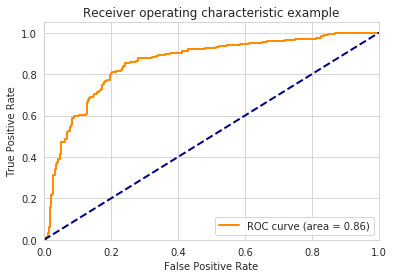

In [300]:
plot_roc(targets, predictions)

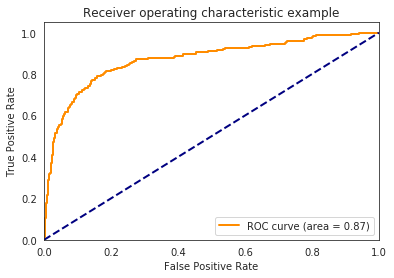

In [285]:
plot_roc(targets, predictions)

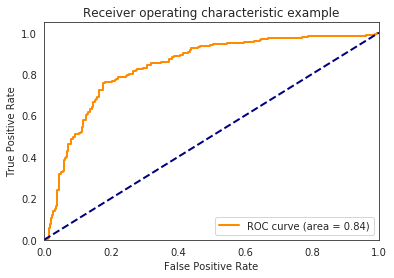

In [272]:
plot_roc(targets, predictions)